In [1]:
import os

In [2]:
%pwd

'c:\\Users\\nikhil\\OneDrive\\Desktop\\ML Projects\\Petrol-Price-Forecasting\\research'

In [3]:
os.chdir("../")

In [4]:
%pwd

'c:\\Users\\nikhil\\OneDrive\\Desktop\\ML Projects\\Petrol-Price-Forecasting'

In [22]:
from dataclasses import dataclass
from pathlib import Path

@dataclass
class ModelEvaluationConfig:
    root_dir: Path
    train_data_path: Path
    test_data_path: Path
    model_path: Path
    predictions_path: Path
    p: int
    d: int
    q: int
    

In [24]:
from ppf.constants import *
from ppf.utils.common import create_directories, read_yaml

class ConfigurationManager:
    def __init__(self, config_filepath = CONFIG_FILE_PATH, params_filepath = PARAMS_FILE_PATH):

        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)

        create_directories([self.config.artifacts_root])

    def get_model_evaluation_config(self) -> ModelEvaluationConfig:

        config = self.config.model_evaluation
        params = self.params.TrainingArguments
        create_directories([config.root_dir])

        model_evaluation_config = ModelEvaluationConfig(
            root_dir = config.root_dir,
            train_data_path = config.train_data_path,
            test_data_path = config.test_data_path,
            model_path = config.model_path,
            predictions_path = config.predictions_path,
            p = params.p,
            d = params.d,
            q = params.q
        )

        return model_evaluation_config 

In [25]:
import pickle
import pandas as pd

In [28]:
class ModelEvaluation:
    def __init__(self, config: ModelEvaluationConfig):
        self.config = config

    def evaluate(self):
        #   loading model
        model = pickle.load(open(self.config.model_path, 'rb'))
        
        # loading datasets
        train_dataset = pd.read_csv(self.config.train_data_path, index_col=False)  
        test_dataset = pd.read_csv(self.config.test_data_path, index_col=False)  
        
        # setting 'Date' as an index column and changing its datatype to Datetime
        train_dataset.set_index('Date', inplace=True)
        train_dataset.index = pd.to_datetime(train_dataset.index)
        test_dataset.set_index('Date', inplace=True)
        test_dataset.index = pd.to_datetime(test_dataset.index)


        # predicting
        # predictions = model.predict(test_dataset)
        
        # print(predictions)
        predictions = model.predict(len(train_dataset), len(train_dataset)+15)
        df_predicted = pd.DataFrame(predictions)
        df_predicted.to_csv(self.config.predictions_path)
        
        train_dataset.plot(legend=True, label='Train', figsize=(10,5))
        predictions.plot(legend=True, label='Prediction')

[2024-05-17 17:16:54,859: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-05-17 17:16:54,863: INFO: common: yaml file: params.yaml loaded successfully]
[2024-05-17 17:16:54,865: INFO: common: directory artifacts created]
[2024-05-17 17:16:54,868: INFO: common: directory artifacts/model_evaluation created]


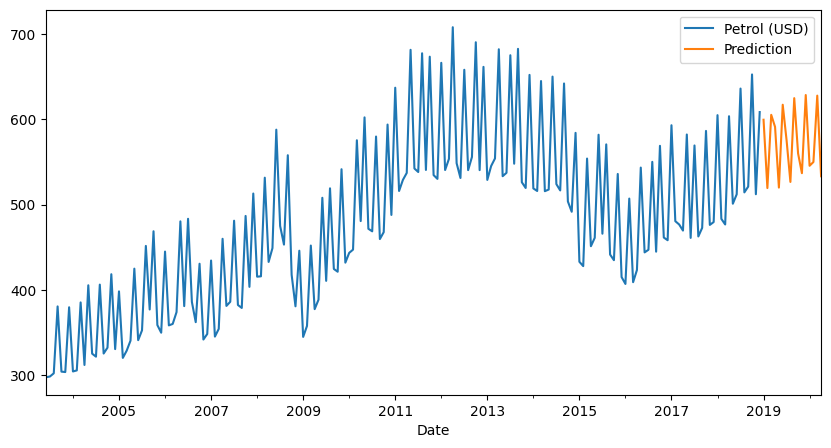

In [29]:
try:
    config = ConfigurationManager()
    model_evaluation_config = config.get_model_evaluation_config()
    model_evaluation_config = ModelEvaluation(config=model_evaluation_config)
    model_evaluation_config.evaluate()
except Exception as e:
    raise e